In [1]:
import numpy as np
import hypothesis as h
import os
import torch
import glob

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import Divider
from mpl_toolkits.axes_grid1.axes_size import Fixed, Scaled

from hypothesis.util.data import NamedDataset, NumpyDataset

h.plot.activate()

In [2]:
base_dir = "/scratch/projects/casbi/workflows"

def get_amortized_outputdir_fct(benchmark, method, regularization=False):
    # ! when flow available, consider the method argument
    def outputdir_fct(simulation_budget):
        if not regularization:
            return base_dir + "/coverage_simulations_and_bias_reduction/{}/output/{}/without-regularization/".format(benchmark, simulation_budget)
        else:
            return base_dir + "/coverage_simulations_and_bias_reduction/{}/output/{}/".format(benchmark, simulation_budget)
    
    return outputdir_fct

def get_sequential_outputdir_fct(benchmark, method):
    
    def outputdir_fct(simulation_budget):
        return base_dir + "/{}/{}/output/{}/".format(method, benchmark, simulation_budget)
        
    return outputdir_fct

methods = ["amortized_ratio", "amortized_flow", "SNPE", "SNL", "SNRE", "rej_ABC", "SMC_ABC"]
method_names = ["NRE", "NPE", "SNPE", "SNL", "SNRE", "Rej-ABC", "SMC-ABC"]

benchmarks = ["slcp", "weinberg", "spatialsir", "mg1", "lotka_volterra", "gw", "streams"]
benchmarks = ['slcp', 'mg1', 'weinberg', 'lotka_volterra', 'spatialsir', 'gw', 'streams']
benchmark_names = ["SLCP", "Weinberg", "Spatial SIR", "MG1", "Lotka Volterra", "GW", "Streams"]
benchmark_names = ["SLCP", "MG1", "Weinberg", "Lotka Volterra", "Spatial SIR", "GW", "Streams"]

experiment_info = {}
for method in methods:
    experiment_info[method] = {}
    
    for benchmark in benchmarks:
        
        experiment_info[method][benchmark] = {}
        
        if method == "amortized_ratio" or method == "amortized_flow":
            experiment_info[method][benchmark]["sequential"] = False
            experiment_info[method][benchmark]["outputdir_fct"] = get_amortized_outputdir_fct(benchmark, method)
            if method == "amortized_ratio":
                experiment_info[method][benchmark]["ratio"] = True
            if method == "amortized_flow":
                experiment_info[method][benchmark]["ratio"] = False
        else:
            experiment_info[method][benchmark]["sequential"] = True
            experiment_info[method][benchmark]["outputdir_fct"] = get_sequential_outputdir_fct(benchmark, method)
            
            
        if (benchmark == "gw" or benchmark == "streams") and experiment_info[method][benchmark]["sequential"]:
            experiment_info[method][benchmark]["empty"] = True
        else:
            experiment_info[method][benchmark]["empty"] = False
            
        experiment_info[method][benchmark]["placeholder"] = True
        
experiment_info["SNL"]["spatialsir"]["empty"] = True
experiment_info["SNL"]["lotka_volterra"]["empty"] = True
    
experiment_info["amortized_ratio"]["slcp"]["placeholder"] = False
experiment_info["amortized_ratio"]["weinberg"]["placeholder"] = False
experiment_info["amortized_ratio"]["spatialsir"]["placeholder"] = False
experiment_info["amortized_ratio"]["mg1"]["placeholder"] = False
experiment_info["amortized_ratio"]["lotka_volterra"]["placeholder"] = False
experiment_info["amortized_ratio"]["streams"]["placeholder"] = False
experiment_info["amortized_ratio"]["gw"]["placeholder"] = False
experiment_info["amortized_flow"]["slcp"]["placeholder"] = False
experiment_info["amortized_flow"]["weinberg"]["placeholder"] = False
experiment_info["amortized_flow"]["spatialsir"]["placeholder"] = False
experiment_info["amortized_flow"]["mg1"]["placeholder"] = False
experiment_info["amortized_flow"]["lotka_volterra"]["placeholder"] = False
experiment_info["amortized_flow"]["streams"]["placeholder"] = False
experiment_info["amortized_flow"]["gw"]["placeholder"] = False
experiment_info["SNPE"]["slcp"]["placeholder"] = False
experiment_info["SNPE"]["weinberg"]["placeholder"] = False
experiment_info["SNPE"]["spatialsir"]["placeholder"] = False
experiment_info["SNPE"]["mg1"]["placeholder"] = False
experiment_info["SNPE"]["lotka_volterra"]["placeholder"] = False
experiment_info["SNL"]["slcp"]["placeholder"] = False
experiment_info["SNL"]["weinberg"]["placeholder"] = False
experiment_info["SNL"]["mg1"]["placeholder"] = False
experiment_info["SNRE"]["slcp"]["placeholder"] = False
experiment_info["SNRE"]["weinberg"]["placeholder"] = False
experiment_info["SNRE"]["spatialsir"]["placeholder"] = False
experiment_info["SNRE"]["mg1"]["placeholder"] = False
experiment_info["SNRE"]["lotka_volterra"]["placeholder"] = False
experiment_info["rej_ABC"]["slcp"]["placeholder"] = False
experiment_info["rej_ABC"]["weinberg"]["placeholder"] = False
experiment_info["rej_ABC"]["spatialsir"]["placeholder"] = False
experiment_info["rej_ABC"]["mg1"]["placeholder"] = False
experiment_info["rej_ABC"]["lotka_volterra"]["placeholder"] = False
experiment_info["SMC_ABC"]["slcp"]["placeholder"] = False
experiment_info["SMC_ABC"]["weinberg"]["placeholder"] = False
experiment_info["SMC_ABC"]["spatialsir"]["placeholder"] = False
experiment_info["SMC_ABC"]["mg1"]["placeholder"] = False
experiment_info["SMC_ABC"]["lotka_volterra"]["placeholder"] = False

credible_interval_levels = [x/20 for x in range(1, 20)]
simulations = [2**x for x in range(10,18)]
title_size = 25
label_size = 25

In [3]:
# Prepare the plotting directory
plotdir = "./plots"
!rm -r $plotdir
!mkdir -p $plotdir

## Utilities

In [4]:
def load_coverage(info, budget, level_index):
    try:
        if info["sequential"]:
            return np.load(info["outputdir_fct"](budget) + "coverage.npy")[level_index]
        else:
            if info["ratio"]:
                ensemble_coverage = np.load(info["outputdir_fct"](budget) + "coverage-classifier-static.npy")[level_index]
                ensemble_coverage_bagging = np.load(info["outputdir_fct"](budget) + "coverage-classifier-bagging.npy")[level_index]
                query = info["outputdir_fct"](budget) + "mlp-0*/coverage.npy"
            else:
                ensemble_coverage = np.load(info["outputdir_fct"](budget) + "coverage-flow-sbi-static.npy")[level_index]
                ensemble_coverage_bagging = np.load(info["outputdir_fct"](budget) + "coverage-flow-sbi-bagging.npy")[level_index]
                query = info["outputdir_fct"](budget) + "flow-sbi-0*/coverage.npy"

            paths = glob.glob(query)
            coverages = [np.load(p)[level_index] for p in paths]

            return np.mean(coverages), np.std(coverages), ensemble_coverage, ensemble_coverage_bagging
        
    except OSError as e:
        print("OSError")
        print("outputdir = {}".format(info["outputdir_fct"](budget)))
        exit()

In [5]:
def plot_coverage(info, level_index, plot_xlabel=True, plot_ylabel=True, plot_xticks=True, plot_yticks=True, 
                  plot_title=None, plot_legend=False, ax=None):
    
    if ax is None:
        ax=plt.axes()
    
    if info["empty"]:
        ax.text(0.5, 0.5, "Intractable", horizontalalignment='center', verticalalignment='center', 
                    transform=ax.transAxes)
        ax.add_patch(Rectangle((0, 0), 1, 1, fill=False, hatch="\\"))
        
    else:
        if info["placeholder"]:
            ax.text(0.5, 0.5, "Placeholder", horizontalalignment='center', verticalalignment='center', 
                    transform=ax.transAxes)
            ax.plot(simulations, [credible_interval_levels[level_index] for _ in simulations], label="Individual")
            if not info["sequential"]:
                ax.plot(simulations, [credible_interval_levels[level_index] for _ in simulations], label="Ensemble")

        else:
            coverage = np.asarray([load_coverage(info, s, level_index) for s in simulations])
            if info["sequential"]:
                ax.plot(simulations, coverage, label="Individual", color="C1")
            else:
                mean_ = np.asarray([cov[0] for cov in coverage])
                std_ = np.asarray([cov[1] for cov in coverage])
                coverages_ensemble = np.asarray([cov[2] for cov in coverage])
                coverages_ensemble_bagging = np.asarray([cov[3] for cov in coverage])

                ax.plot(simulations, coverages_ensemble, label="Ensemble")
                ax.plot(simulations, mean_, label="Individual")
                ax.fill_between(simulations, mean_ - std_, mean_ + std_, alpha=0.1, color="C1")
                ax.plot(simulations, coverages_ensemble_bagging, label="Ensemble bagging")

        ax.set_xscale("log")
        
        ax.axhline(credible_interval_levels[level_index], linestyle=':', alpha=.75, label="Nominal coverage probability")
    
    if plot_xlabel:
        ax.set_xlabel("Simulation budget", fontdict = {'fontsize': label_size})
    if plot_ylabel:
        ax.set_ylabel("Empirical coverage", fontdict = {'fontsize': label_size})
    if not plot_xticks:
        plt.setp(ax.get_xticklabels(), visible=False)
    if not plot_yticks:
        plt.setp(ax.get_yticklabels(), visible=False)
    if plot_title is not None:
        ax.set_title(plot_title)
    
    if plot_legend:
        ax.legend()

In [6]:
def plot_multiple_coverage(info, plot_xlabel=True, plot_ylabel=True, plot_xticks=True, plot_yticks=True, 
                       plot_title=None, plot_legend=False, ax=None, ensemble=False, bagging=False):
    
    #colors = ["#279AF1", "#298bd8", "#2a80c6", "#2a75b5", "#285f92", "#213e5c", "#172331",  "#000000"]
    viridis = cm.get_cmap('viridis', len(simulations))
    colors = viridis.colors[::-1]
    
    if ax is None:
        ax=plt.axes()
        
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    if info["empty"]:
        ax.text(0.5, 0.5, "Intractable", horizontalalignment='center', verticalalignment='center', 
                    transform=ax.transAxes)
        ax.add_patch(Rectangle((0, 0), 1, 1, fill=False, hatch="\\"))
        
    else:
        if info["placeholder"]:
            ax.text(0.5, 0.5, "Placeholder", horizontalalignment='center', verticalalignment='center', 
                    transform=ax.transAxes)
            ax.plot(credible_interval_levels, credible_interval_levels)

        else:
            coverage = [[load_coverage(info, s, level_index) for level_index in range(len(credible_interval_levels))] 
                        for s in simulations]
            if not info["sequential"]:
                if ensemble:
                    if bagging:
                        coverage = [[x[3] for x in y] for y in coverage]
                    else:
                        coverage = [[x[2] for x in y] for y in coverage]
                else:
                    coverage = [[x[0] for x in y] for y in coverage]
                

            for c, s, cov in zip(colors, simulations, coverage):
                ax.plot(credible_interval_levels, cov, label="{} samples".format(s), c=c)
                
        ax.plot(credible_interval_levels, credible_interval_levels, linestyle=':', alpha=.75, 
            label="Calibrated estimator")
    
    if plot_xlabel:
        ax.set_xlabel("Confidence level", fontdict = {'fontsize': label_size})
    if plot_ylabel:
        ax.set_ylabel("Empirical coverage", fontdict = {'fontsize': label_size})
    if not plot_xticks:
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        ax.set_xticks([0.0, 0.5, 1.0])
        #ax.set_xticklabels(['0.0', '', '', '', '', '0.5', '', '', '', '', '1.0'])
        ax.set_xticklabels(['0', '0.5', '1'])
    if not plot_yticks:
        plt.setp(ax.get_yticklabels(), visible=False)
    else:
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.set_yticklabels(['0', '0.5', '1'])
    if plot_title is not None:
        ax.set_title(plot_title)
    if plot_legend:
        ax.legend()

In [7]:
def plot_multiple_coverage_single_sb(info, simulation_budget, plot_xlabel=True, plot_ylabel=True, plot_xticks=True, plot_yticks=True, 
                                     plot_title=None, plot_legend=False, ax=None, include_bagging=True):
    
    #colors = ["#279AF1", "#298bd8", "#2a80c6", "#2a75b5", "#285f92", "#213e5c", "#172331",  "#000000"]
    viridis = cm.get_cmap('viridis', len(simulations))
    colors = viridis.colors[::-1]
    
    if ax is None:
        ax=plt.axes()
    
    if info["empty"]:
        ax.text(0.5, 0.5, "Intractable", horizontalalignment='center', verticalalignment='center', 
                    transform=ax.transAxes)
        ax.add_patch(Rectangle((0, 0), 1, 1, fill=False, hatch="\\"))
        
    else:
        if info["placeholder"]:
            ax.text(0.5, 0.5, "Placeholder", horizontalalignment='center', verticalalignment='center', 
                    transform=ax.transAxes)
            ax.plot(credible_interval_levels, credible_interval_levels)

        else:
            coverage = [load_coverage(info, simulation_budget, level_index) for level_index in range(len(credible_interval_levels))]
            if info["sequential"]:
                ax.plot(credible_interval_levels, coverage, label="Individual", color="C1")
            else:
                mean_ = np.asarray([cov[0] for cov in coverage])
                std_ = np.asarray([cov[1] for cov in coverage])
                coverages_ensemble = np.asarray([cov[2] for cov in coverage])
                coverages_ensemble_bagging = np.asarray([cov[3] for cov in coverage])

                ax.plot(credible_interval_levels, coverages_ensemble, label="Ensemble")
                ax.plot(credible_interval_levels, mean_, label="Individual")
                ax.fill_between(credible_interval_levels, mean_ - std_, mean_ + std_, alpha=0.1, color="C1")
                if include_bagging:
                    ax.plot(credible_interval_levels, coverages_ensemble_bagging, label="Ensemble bagging")
                
            ax.plot(credible_interval_levels, credible_interval_levels, linestyle=':', alpha=.75, 
            label="Calibrated estimator")
    
    if plot_xlabel:
        ax.set_xlabel("Confidence level", fontdict = {'fontsize': label_size})
    if plot_ylabel:
        ax.set_ylabel("Empirical coverage", fontdict = {'fontsize': label_size})
    if not plot_xticks:
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        ax.set_xticks([0.0, 0.5, 1.0])
        ax.set_xticklabels(['0', '0.5', '1'])
    if not plot_yticks:
        plt.setp(ax.get_yticklabels(), visible=False)
    else:
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.set_yticklabels(['0', '0.5', '1'])
    if plot_title is not None:
        ax.set_title(plot_title)
    if plot_legend:
        ax.legend()

In [8]:
def empty_axes(ax):
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

In [9]:
def summary_plot(save_name, level_index=None, multiple_coverage=False, single_sb=False, simulation_budget=None, include_bagging=False):
    
    # Construct grid
    horiz_sizes = [0.75, 0.75]
    
    nb_methods = len(methods)
    if multiple_coverage and not single_sb:
        for method in methods:
            if not experiment_info[method][benchmarks[0]]["sequential"]:
                if include_bagging:
                    nb_methods += 2
                else:
                    nb_methods += 1
                
    for _ in range(nb_methods):
        horiz_sizes += [2.5, 0.25]
    horiz_sizes = horiz_sizes[:-1]
    
    if multiple_coverage:
        vert_sizes = [1.5, 0.5]
    else:
        vert_sizes = [0.75, 0.5]
        
    for _ in range(len(benchmarks)):
        vert_sizes += [2.5, 0.15]
    
    vert_sizes.append(0.75)
    
    fig = plt.figure(figsize=[sum(horiz_sizes), sum(vert_sizes)])
    horiz = [Fixed(x) for x in horiz_sizes]
    vert = [Fixed(x) for x in vert_sizes]

    rect = (0.1, 0.1, 0.8, 0.8) # Ignored
    divider = Divider(fig, rect, horiz, vert, aspect=False)
    
    # Plots
    plot_axes = []
    base_legend_ax = None
    for i, benchmark in enumerate(benchmarks):
        plot_axes.append([])
        x_offset = 0
        for j, method in enumerate(methods):
            j += x_offset
            if i == len(benchmarks) - 1 and j == 0:
                plot_xlabel = True
                plot_ylabel = True
            else:
                plot_xlabel = False
                plot_ylabel = False
            
            if i == len(benchmarks) - 1:
                plot_xticks = True
            else:
                plot_xticks = False
                
            if j == 0:
                plot_yticks = True
            else:
                plot_yticks = False
            
            if i == 0 and j == 0:
                plot_axes[i].append(fig.add_axes(rect, label="plot_axes_{}_{}".format(i, j)))
            
            elif i == 0 and not j == 0:
                plot_axes[i].append(fig.add_axes(rect, label="plot_axes_{}_{}".format(i, j),
                                                 sharey=plot_axes[i][0]))
                
            elif not i == 0 and j == 0:
                plot_axes[i].append(fig.add_axes(rect, label="plot_axes_{}_{}".format(i, j),
                                                 sharex=plot_axes[0][j]))
            else:
                plot_axes[i].append(fig.add_axes(rect, label="plot_axes_{}_{}".format(i, j),
                                                 sharex=plot_axes[0][j], sharey=plot_axes[i][0]))
                
                    
            plot_axes[i][j].set_axes_locator(divider.new_locator(nx=2*(j+1), ny=2*(len(benchmarks) - i)))
            
            if multiple_coverage and not single_sb and not experiment_info[method][benchmarks[0]]["sequential"]:
                if i == 0:
                    plot_axes[i].append(fig.add_axes(rect, label="plot_axes_{}_{}".format(i, j+1),
                                                     sharey=plot_axes[i][0]))
                    if include_bagging:
                        plot_axes[i].append(fig.add_axes(rect, label="plot_axes_{}_{}".format(i, j+2),
                                                         sharey=plot_axes[i][0]))
                        
                else:
                    plot_axes[i].append(fig.add_axes(rect, label="plot_axes_{}_{}".format(i, j+1),
                                                     sharex=plot_axes[0][j+1], sharey=plot_axes[i][0]))
                    
                    if include_bagging:
                        plot_axes[i].append(fig.add_axes(rect, label="plot_axes_{}_{}".format(i, j+2),
                                                         sharex=plot_axes[0][j+2], sharey=plot_axes[i][0]))
                        
                
                plot_axes[i][j+1].set_axes_locator(divider.new_locator(nx=2*(j+2), ny=2*(len(benchmarks) - i)))
                if include_bagging:
                    plot_axes[i][j+2].set_axes_locator(divider.new_locator(nx=2*(j+3), ny=2*(len(benchmarks) - i)))
            
            if multiple_coverage:
                if single_sb:
                    plot_multiple_coverage_single_sb(experiment_info[method][benchmark], simulation_budget, 
                                                     plot_xlabel=plot_xlabel, plot_ylabel=plot_ylabel, 
                                                     plot_xticks=plot_xticks, plot_yticks=plot_yticks, 
                                                     ax=plot_axes[i][j])
                else:
                    plot_multiple_coverage(experiment_info[method][benchmark], plot_xlabel=plot_xlabel, 
                                           plot_ylabel=plot_ylabel, plot_xticks=plot_xticks, plot_yticks=plot_yticks, 
                                           ax=plot_axes[i][j])
                    
                    if not experiment_info[method][benchmarks[0]]["sequential"]:
                        plot_multiple_coverage(experiment_info[method][benchmark], plot_xlabel=False, 
                                               plot_ylabel=False, plot_xticks=plot_xticks, plot_yticks=False, 
                                               ax=plot_axes[i][j+1], ensemble=True, bagging=False)
                        if include_bagging:
                            plot_multiple_coverage(experiment_info[method][benchmark], plot_xlabel=False, 
                                                   plot_ylabel=False, plot_xticks=plot_xticks, 
                                                   plot_yticks=False, ax=plot_axes[i][j+2], ensemble=True, 
                                                   bagging=True)
                            
                            x_offset += 2
                        else:
                            x_offset += 1
            else:
                plot_coverage(experiment_info[method][benchmark], level_index, plot_xlabel=plot_xlabel, 
                              plot_ylabel=plot_ylabel, plot_xticks=plot_xticks, plot_yticks=plot_yticks, 
                              ax=plot_axes[i][j])
            
            if not experiment_info[method][benchmark]["sequential"] and not experiment_info[method][benchmark]["placeholder"] and base_legend_ax is None:
                base_legend_ax = plot_axes[i][j]
    
    # Benchmark titles
    benchmark_axes = []
    for i, benchmark in enumerate(benchmarks):
        benchmark_axes.append(fig.add_axes(rect, label="benchmark_axes_{}".format(i)))
        benchmark_axes[i].set_axes_locator(divider.new_locator(nx=0, ny=2*(len(benchmarks) - i)))
        benchmark_axes[i].set_axis_off()
        benchmark_axes[i].text(0.5, 0.5, benchmark_names[i], horizontalalignment='center', 
                               verticalalignment='center', transform=benchmark_axes[i].transAxes, rotation=90,
                               fontsize=title_size)
    
    # Method titles
    method_axes = []
    x_offset = 0
    for i, method in enumerate(methods):
        i += x_offset
        method_axes.append(fig.add_axes(rect, label="method_axes_{}".format(i)))
        method_axes[i].set_axes_locator(divider.new_locator(nx=2*(i+1), ny=2*(len(benchmarks)+1)))
        method_axes[i].set_axis_off()
        method_axes[i].text(0.5, 0.5, method_names[i-x_offset], horizontalalignment='center', 
                            verticalalignment='center', transform=method_axes[i].transAxes, 
                            fontdict = {'fontsize': title_size})
        
        if multiple_coverage and not single_sb and not experiment_info[method][benchmarks[0]]["sequential"]:
            
            method_axes.append(fig.add_axes(rect, label="method_axes_{}".format(i+1)))
            method_axes[i+1].set_axes_locator(divider.new_locator(nx=2*(i+2), ny=2*(len(benchmarks)+1)))
            method_axes[i+1].set_axis_off()
            method_axes[i+1].text(0.5, 0.5, method_names[i-x_offset] + " ensemble", horizontalalignment='center', 
                                  verticalalignment='center', transform=method_axes[i+1].transAxes, 
                                  fontdict = {'fontsize': title_size})
            
            if include_bagging:
                method_axes.append(fig.add_axes(rect, label="method_axes_{}".format(i+2)))
                method_axes[i+2].set_axes_locator(divider.new_locator(nx=2*(i+3), ny=2*(len(benchmarks)+1)))
                method_axes[i+2].set_axis_off()
                method_axes[i+2].text(0.5, 0.5, method_names[i-x_offset] + " ensemble bagging", horizontalalignment='center', 
                                      verticalalignment='center', transform=method_axes[i+2].transAxes,
                                      fontdict = {'fontsize': title_size})

                x_offset += 2
            else:
                x_offset += 1
    
    # Legend
    ax_legend = fig.add_axes(rect, label="legend ax")
    ax_legend.set_axes_locator(divider.new_locator(nx=2, nx1=2*nb_methods+1, ny=0))
    ax_legend.set_axis_off()
    han, l = base_legend_ax.get_legend_handles_labels()
    ax_legend.legend(han, l, ncol=4, loc="center")

    plt.savefig(save_name)
    

In [10]:
def summary_plot_ensemble(save_name, simulation_budgets=[1024], include_bagging=False):
    # Construct grid
    horiz_sizes = [0.75, 0.75]
    
    amortized_methods = [method for method in methods if not experiment_info[method][benchmarks[0]]["sequential"]]
    nb_methods = len(amortized_methods) * len(simulation_budgets)
                
    for _ in range(nb_methods):
        horiz_sizes += [2.5, 0.25]
    horiz_sizes = horiz_sizes[:-1]
    
    vert_sizes = [1.5, 0.5]
        
    for _ in range(len(benchmarks)):
        vert_sizes += [2.5, 0.15]
    
    vert_sizes += [0.75, 0.25, 0.75]
    
    fig = plt.figure(figsize=[sum(horiz_sizes), sum(vert_sizes)])
    horiz = [Fixed(x) for x in horiz_sizes]
    vert = [Fixed(x) for x in vert_sizes]

    rect = (0.1, 0.1, 0.8, 0.8) # Ignored
    divider = Divider(fig, rect, horiz, vert, aspect=False)
    
    # Plots
    plot_axes = []
    base_legend_ax = None
    for i, benchmark in enumerate(benchmarks):
        plot_axes.append([])
        for j, method in enumerate(amortized_methods):
            j = j*len(simulation_budgets)
            
            if i == len(benchmarks) - 1 and j == 0:
                plot_xlabel = True
                plot_ylabel = True
            else:
                plot_xlabel = False
                plot_ylabel = False
            
            if i == len(benchmarks) - 1:
                plot_xticks = True
            else:
                plot_xticks = False
                
            if j == 0:
                plot_yticks = True
            else:
                plot_yticks = False
            
            if i == 0 and j == 0:
                plot_axes[i].append(fig.add_axes(rect, label="plot_axes_{}_{}".format(i, j)))
            
            elif i == 0 and not j == 0:
                plot_axes[i].append(fig.add_axes(rect, label="plot_axes_{}_{}".format(i, j),
                                                 sharey=plot_axes[i][0]))
                
            elif not i == 0 and j == 0:
                plot_axes[i].append(fig.add_axes(rect, label="plot_axes_{}_{}".format(i, j),
                                                 sharex=plot_axes[0][j]))
            else:
                plot_axes[i].append(fig.add_axes(rect, label="plot_axes_{}_{}".format(i, j),
                                                 sharex=plot_axes[0][j], sharey=plot_axes[i][0]))
            
            plot_axes[i][j].set_axes_locator(divider.new_locator(nx=2*(j+1), ny=2*(len(benchmarks) - i)))
            
            for k in range(1, len(simulation_budgets)):
                if i == 0:
                    plot_axes[i].append(fig.add_axes(rect, label="plot_axes_{}_{}".format(i, j+k),
                                                 sharey=plot_axes[i][0]))
                else:
                    plot_axes[i].append(fig.add_axes(rect, label="plot_axes_{}_{}".format(i, j+k),
                                                 sharex=plot_axes[0][j+k], sharey=plot_axes[i][0]))
                    
                plot_axes[i][j+k].set_axes_locator(divider.new_locator(nx=2*(j+k+1), ny=2*(len(benchmarks) - i)))
            
            
            for k, budget in enumerate(simulation_budgets):
                if k == 0:
                    plot_multiple_coverage_single_sb(experiment_info[method][benchmark], budget, 
                                                             plot_xlabel=plot_xlabel, plot_ylabel=plot_ylabel, 
                                                             plot_xticks=plot_xticks, plot_yticks=plot_yticks, 
                                                            ax=plot_axes[i][j], include_bagging=include_bagging)
                else:
                    plot_multiple_coverage_single_sb(experiment_info[method][benchmark], budget, 
                                                             plot_xlabel=False, plot_ylabel=False, 
                                                             plot_xticks=plot_xticks, plot_yticks=False, 
                                                             ax=plot_axes[i][j+k], include_bagging=include_bagging)
            
            
            if not experiment_info[method][benchmark]["sequential"] and not experiment_info[method][benchmark]["placeholder"] and base_legend_ax is None:
                base_legend_ax = plot_axes[i][j]
                
    # Benchmark titles
    benchmark_axes = []
    for i, benchmark in enumerate(benchmarks):
        benchmark_axes.append(fig.add_axes(rect, label="benchmark_axes_{}".format(i)))
        benchmark_axes[i].set_axes_locator(divider.new_locator(nx=0, ny=2*(len(benchmarks) - i)))
        benchmark_axes[i].set_axis_off()
        benchmark_axes[i].text(0.5, 0.5, benchmark_names[i], horizontalalignment='center', 
                               verticalalignment='center', transform=benchmark_axes[i].transAxes, rotation=90,
                               fontdict = {'fontsize': title_size})
        
    # Method titles
    top_method_axes = []
    method_axes = []
    for i, method in enumerate(amortized_methods):
        j = i*len(simulation_budgets)
        
        top_method_axes.append(fig.add_axes(rect, label="top_method_axes_{}".format(i)))
        top_method_axes[i].set_axes_locator(divider.new_locator(nx=2*(j+1), ny=2*(len(benchmarks)+2)))
        top_method_axes[i].set_axis_off()
        top_method_axes[i].text(0.5, 0.5, method_names[i], horizontalalignment='center', 
                                verticalalignment='center', transform=top_method_axes[i].transAxes,
                                fontdict = {'fontsize': title_size})
        
        
        for k, budget in enumerate(simulation_budgets):
            method_axes.append(fig.add_axes(rect, label="method_axes_{}".format(j+k)))
            method_axes[j+k].set_axes_locator(divider.new_locator(nx=2*(j+k+1), ny=2*(len(benchmarks)+1)))
            method_axes[j+k].set_axis_off()
            method_axes[j+k].text(0.5, 0.5, "{} samples".format(budget), horizontalalignment='center', 
                                  verticalalignment='center', transform=method_axes[j+k].transAxes,
                                  fontdict = {'fontsize': title_size})
    
    # Legend
    ax_legend = fig.add_axes(rect, label="legend ax")
    ax_legend.set_axes_locator(divider.new_locator(nx=2, nx1=2*nb_methods+1, ny=0))
    ax_legend.set_axis_off()
    han, l = base_legend_ax.get_legend_handles_labels()
    if include_bagging:
        ax_legend.legend(han, l, ncol=4, loc="center")
    else:
        ax_legend.legend(han, l, ncol=3, loc="center")

    plt.savefig(save_name)

<ipython-input-9-354dd78b3f08>:181: UserWarning: AutoMinorLocator does not work with logarithmic scale
  plt.savefig(save_name)
<ipython-input-9-354dd78b3f08>:181: UserWarning: AutoMinorLocator does not work with logarithmic scale
  plt.savefig(save_name)
<ipython-input-9-354dd78b3f08>:181: UserWarning: AutoMinorLocator does not work with logarithmic scale
  plt.savefig(save_name)
<ipython-input-9-354dd78b3f08>:181: UserWarning: AutoMinorLocator does not work with logarithmic scale
  plt.savefig(save_name)
/home/jhermans/anaconda/envs/casbi/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


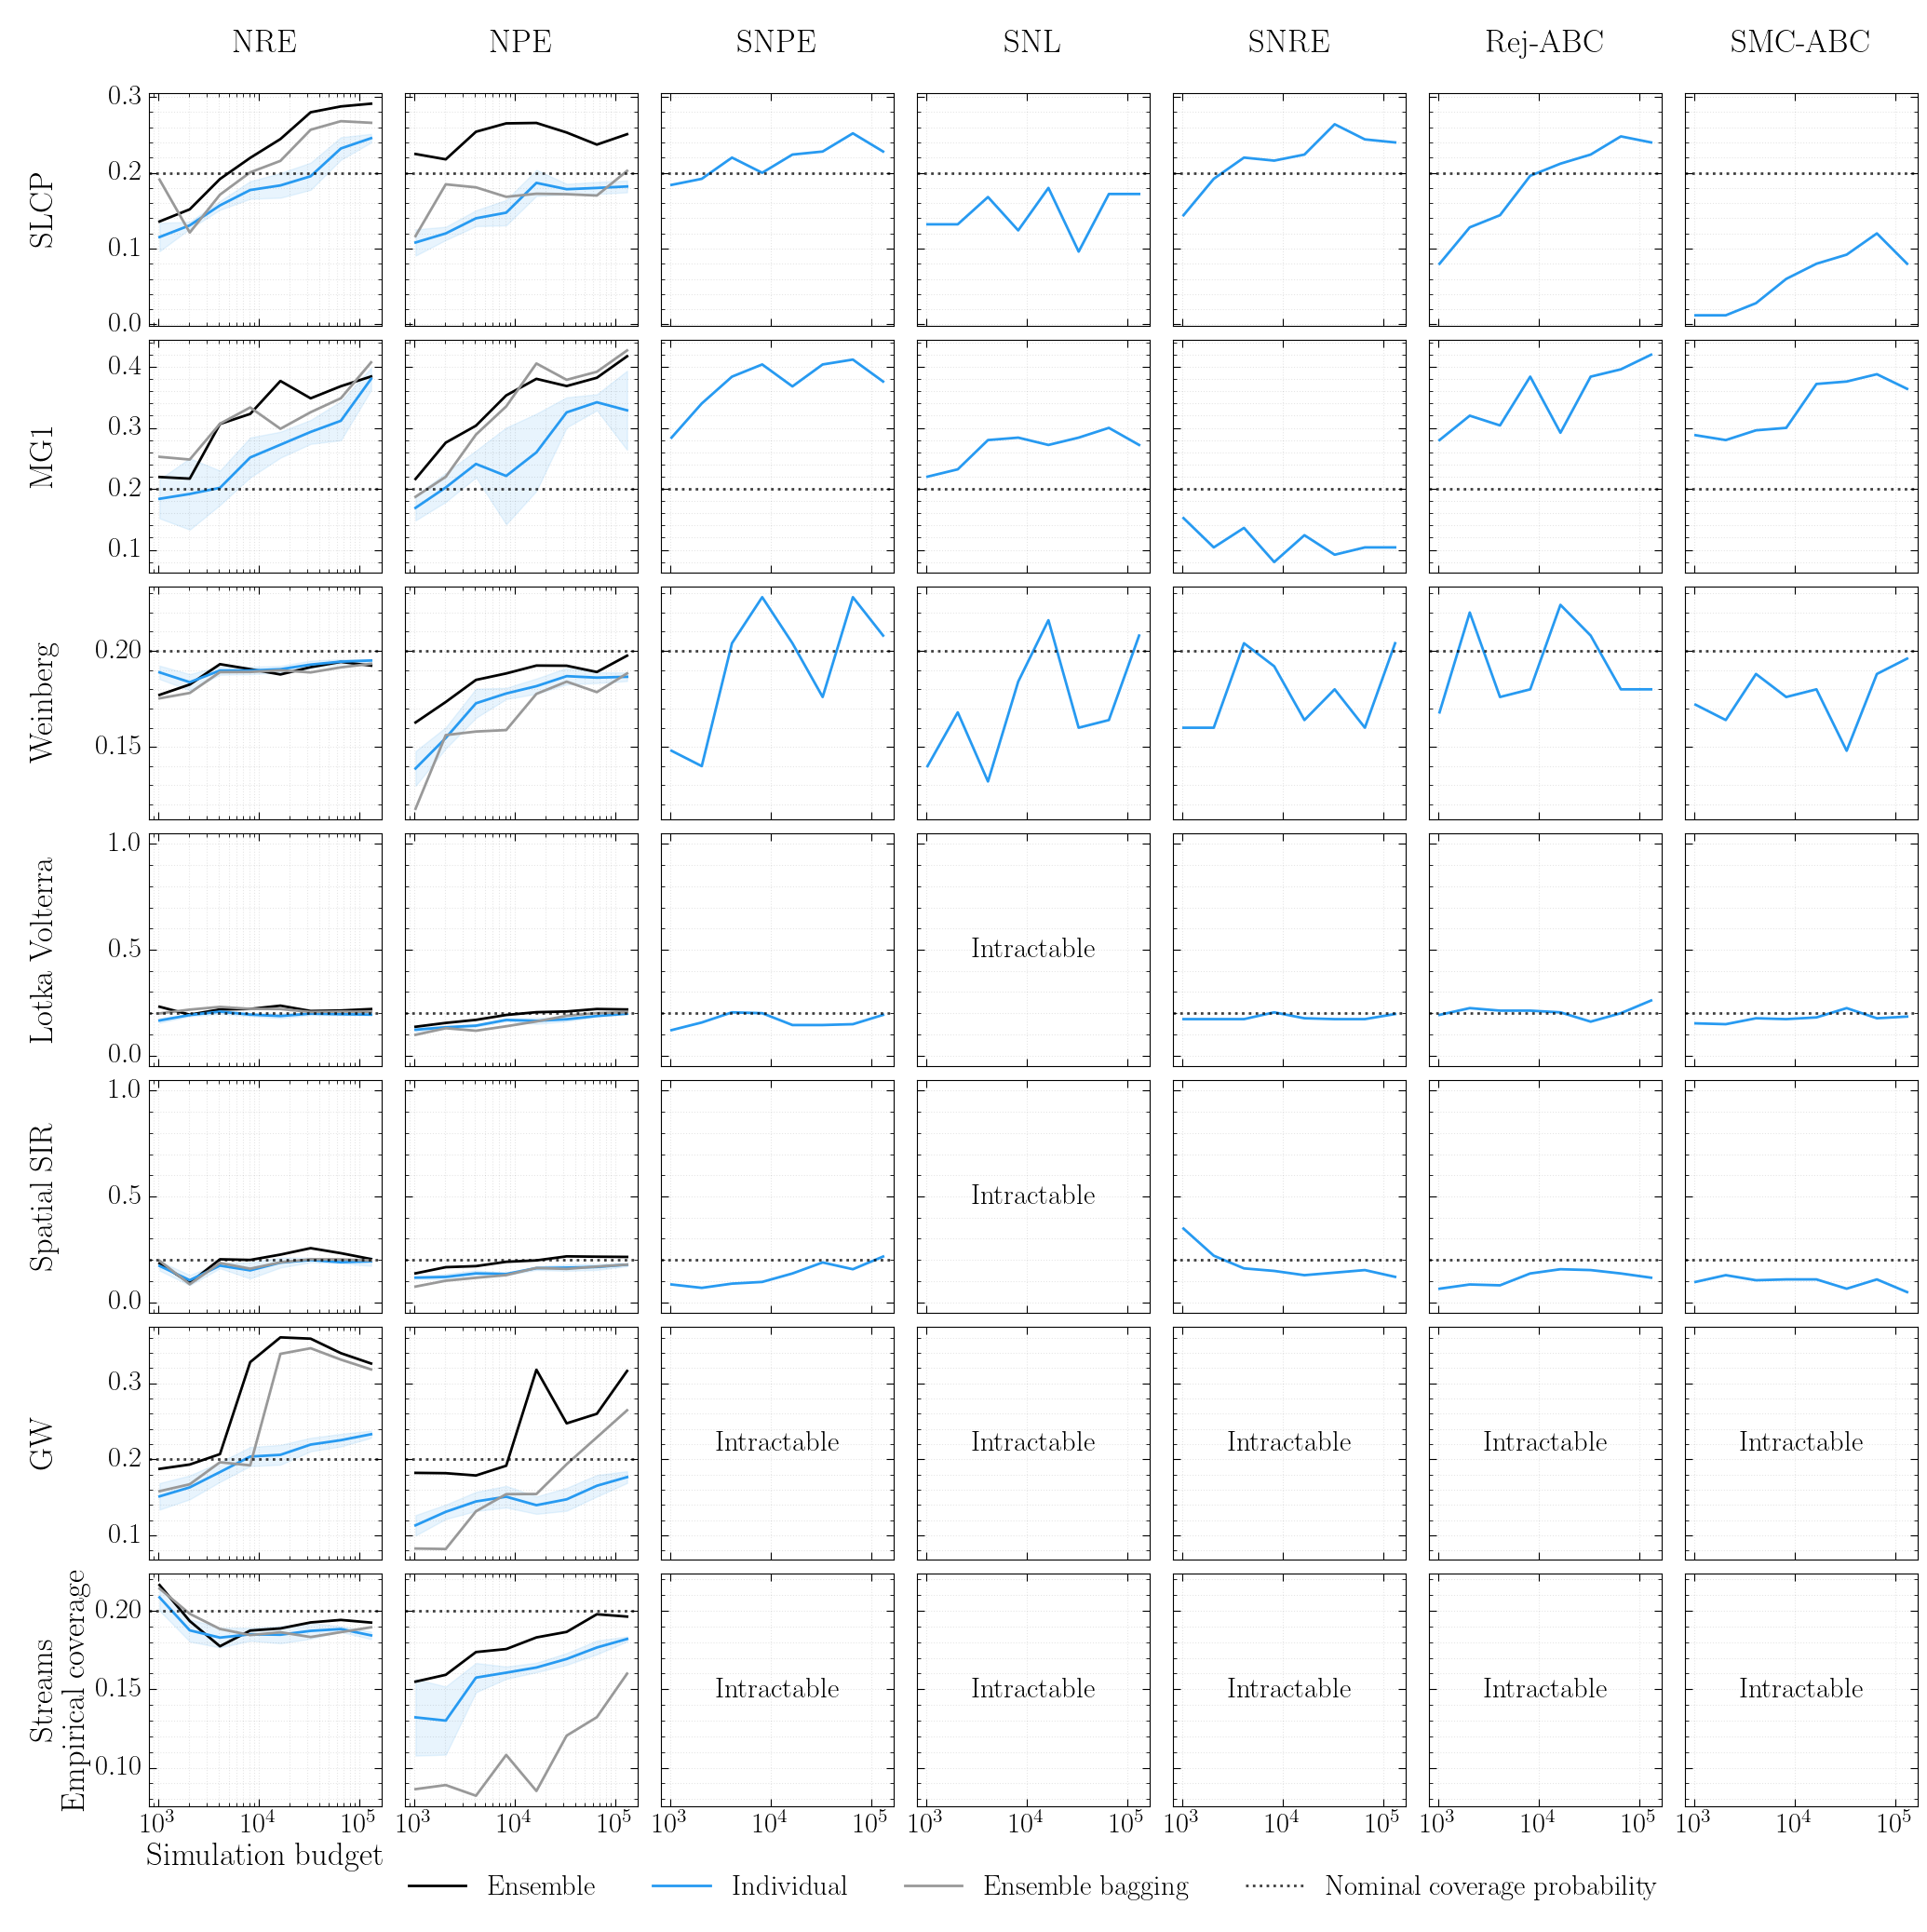

In [11]:
summary_plot("coverage_20.pdf", 3)

In [ ]:
summary_plot("coverage_70.pdf", 13)

In [ ]:
summary_plot("coverage_95.pdf", 18)

In [ ]:
summary_plot("coverage_multi_sb_1024.pdf", multiple_coverage=True, single_sb=True, simulation_budget=1024)

In [ ]:
summary_plot("coverage_multi_sb_8192.pdf", multiple_coverage=True, single_sb=True, simulation_budget=8192)

In [ ]:
summary_plot("coverage_multi_sb_65536.pdf", multiple_coverage=True, single_sb=True, simulation_budget=65536)

In [ ]:
summary_plot("coverage_multi.pdf", multiple_coverage=True)

In [ ]:
summary_plot("coverage_multi_bagging.pdf", multiple_coverage=True, include_bagging=True)

In [ ]:
summary_plot_ensemble("coverage_multi_ensemble.pdf", simulation_budgets=[1024, 8192, 32768, 131072], include_bagging=True)